# Raman Spectroscopy Generative Adversarial Network

## Import libraries and read data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl   
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
import glob

2023-09-20 23:21:49.676508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 23:21:49.707675: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 23:21:49.708300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 23:21:50.306353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [57]:
mpl.rc('figure.subplot', left=.2, right=.8, bottom=.2, top=.8)
width, height = 20, 6
mpl.rcParams['figure.figsize'] = [width, height]
# custom_colors = plt.rcParams['axes.prop_cycle']() 

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
custom_xticks = [0] + [i for i in range(350, 1651, 50)]
custom_xlim = (0, 1331)

sns.set_context("paper", rc={"lines.linewidth": 1})
sns.set_style('whitegrid')

In [3]:
data = pd.read_csv("../input/data.csv")

### txt to csv

In [4]:
def txt2csv(directory_path, diagnostic, format='v1'):
    txt_files = glob.glob(directory_path + '/*.txt')
    column_names = ['Wavelength', 'Intensity']
    samples = []
    for file in txt_files:
        if format == 'v1':
            df = pd.read_csv(file, skiprows=4, names=column_names)[:-1]
        elif format == 'v2':
            df = pd.read_csv(file, skiprows=1, names=column_names)
        df = df.pivot_table(index=None, values='Intensity', columns='Wavelength', sort=False)
        df['Diagnostic'] = diagnostic
        samples.append(df)
    return pd.concat(samples, ignore_index=True)

In [5]:
# tmp_df = txt2csv('../input/raw/blank-negative', diagnostic='Blank', format='v1')

In [6]:
# tmp_df.columns = tmp_df.columns.astype(str)

In [7]:
# data = pd.concat([data, tmp_df], ignore_index=True)

In [8]:
# data['COVID-19_Status'] = np.where(data['Diagnostic'].isin(['Blank', 'Streptavidin']), 'negative', 'positive')

In [9]:
display(data.head().T)

0             1             2          3  \
320                 -1.388896     16.722093      0.329687 -10.598846   
321                   0.05821     -1.186429     -0.747993  -5.978379   
322                  5.898464    -10.186022     -1.588051   1.822014   
323                  5.849397     -3.832706      0.152671   12.90642   
324                   2.37903      12.73007      5.357345  21.049637   
...                       ...           ...           ...        ...   
1648                 1.384356     -4.633642     -5.380405  10.001486   
1649                 16.59277     -6.431111     -6.852814    1.22302   
1650                 8.760738     25.847542     -2.682321   1.914469   
Diagnostic       Streptavidin  Streptavidin  Streptavidin          S   
COVID-19_Status      negative      negative      negative   positive   

                         4  
320              10.015236  
321              12.575455  
322              13.012607  
323              13.932454  
324              13.677982  
...                    ...  
1648             35.561525  
1649             37.348663  
1650              11.53166  
Diagnostic               S  
COVID-19_Status   positive  

[1333 rows x 5 columns]

In [10]:
print(data.shape)

(35, 1333)


In [11]:
# data.to_csv('../input/data.csv', index=None)

## Data analyze and visualize

### h3

In [12]:
X = data.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
X.columns = X.columns.astype(int)
y_diagnostic = data['Diagnostic']
y_covid_status = data['COVID-19_Status']

In [13]:
wavelength = X.columns
intensity = X.values

In [14]:
unique_diagnostic = y_diagnostic.unique()

### Visualize raman spectrum

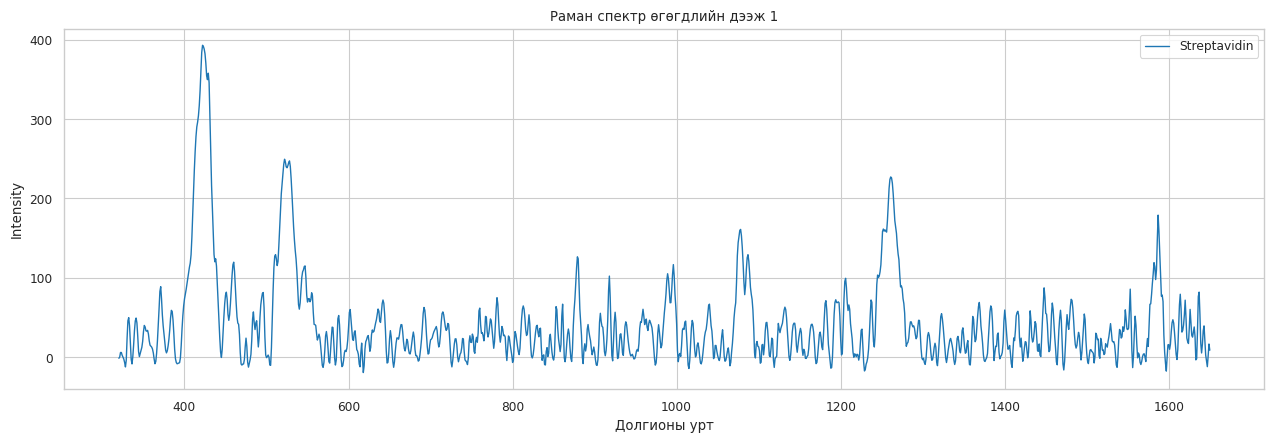

In [58]:
fig, ax = plt.subplots()

sns.lineplot(x=wavelength, y=intensity[0], ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1")
ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.legend()

plt.show()

# plt.savefig('../figures/RamanSpectra_Fig1_20230920.png')

### h3 plot count


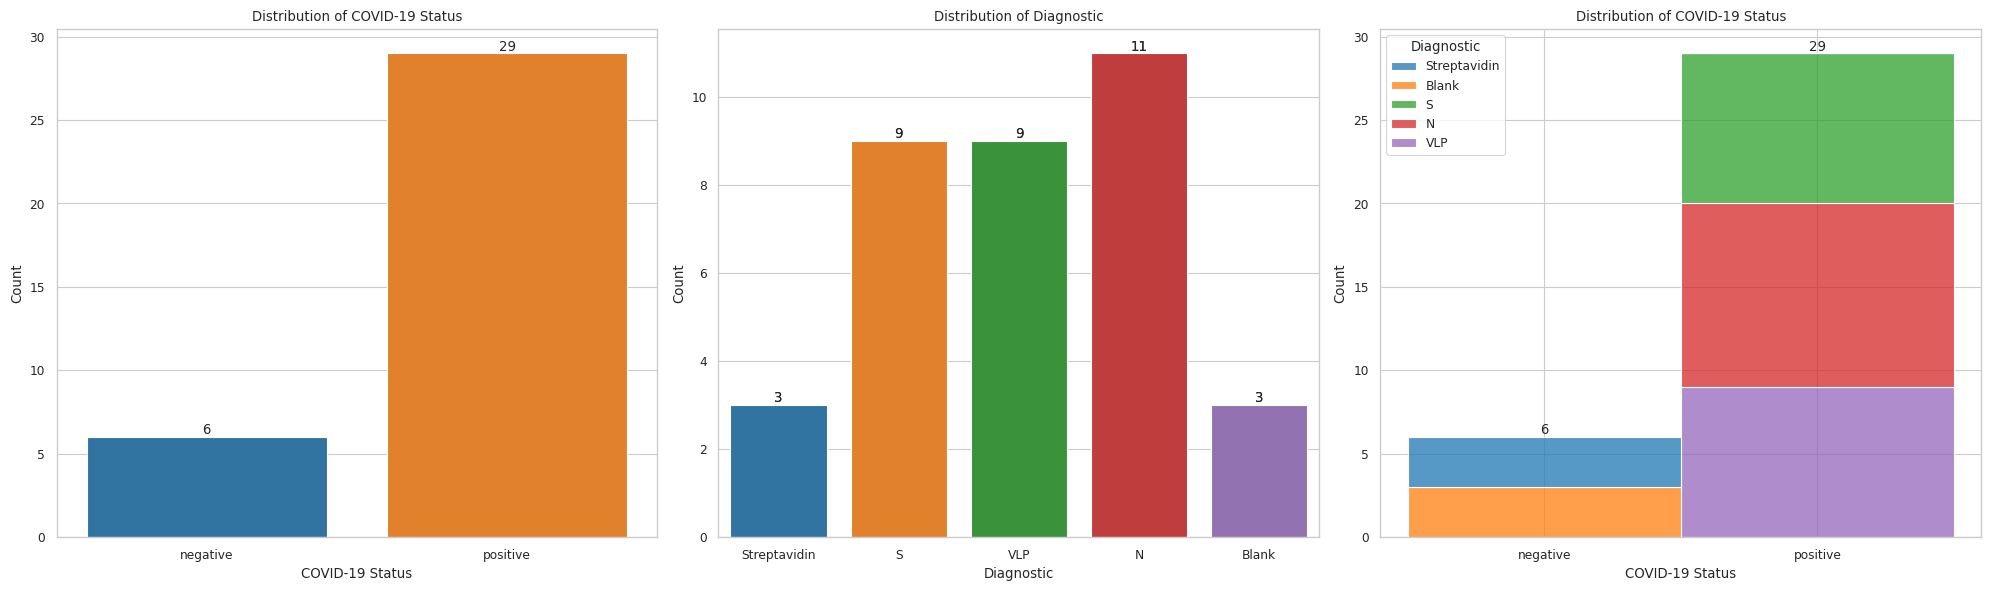

In [59]:
fig, axs = plt.subplots(ncols=3)

sns.countplot(x=y_covid_status, ax=axs[0])
abs_values_covid_status = y_covid_status.value_counts().values
axs[0].bar_label(container=axs[0].containers[0], label=abs_values_covid_status)
axs[0].set_xlabel('COVID-19 Status')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of COVID-19 Status')

sns.countplot(x=y_diagnostic, ax=axs[1])
abs_values_diagnostic = y_diagnostic.value_counts().values
axs[1].bar_label(container=axs[1].containers[0], label=abs_values_diagnostic)
axs[1].set_xlabel('Diagnostic')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Diagnostic')

sns.countplot(x=y_diagnostic, ax=axs[1])
abs_values_diagnostic = y_diagnostic.value_counts().values
axs[1].bar_label(container=axs[1].containers[0], label=abs_values_diagnostic)
axs[1].set_xlabel('Diagnostic')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Diagnostic')

sns.histplot(data=data.sort_values('COVID-19_Status'), x='COVID-19_Status', hue='Diagnostic', ax=axs[2], multiple="stack")
axs[2].bar_label(container=axs[0].containers[0], label=abs_values_covid_status)
axs[2].set_xlabel('COVID-19 Status')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of COVID-19 Status')

plt.tight_layout()
plt.show()

# plt.savefig('../figures/DistributionOfLabels_20230920.png', bbox_inches='tight')

### tus tusad songoson

In [17]:
selected_intensity = []

for diagnostic in unique_diagnostic:
    filtered_intensity = intensity[y_diagnostic == diagnostic]
    selected_intensity.append(filtered_intensity[0])

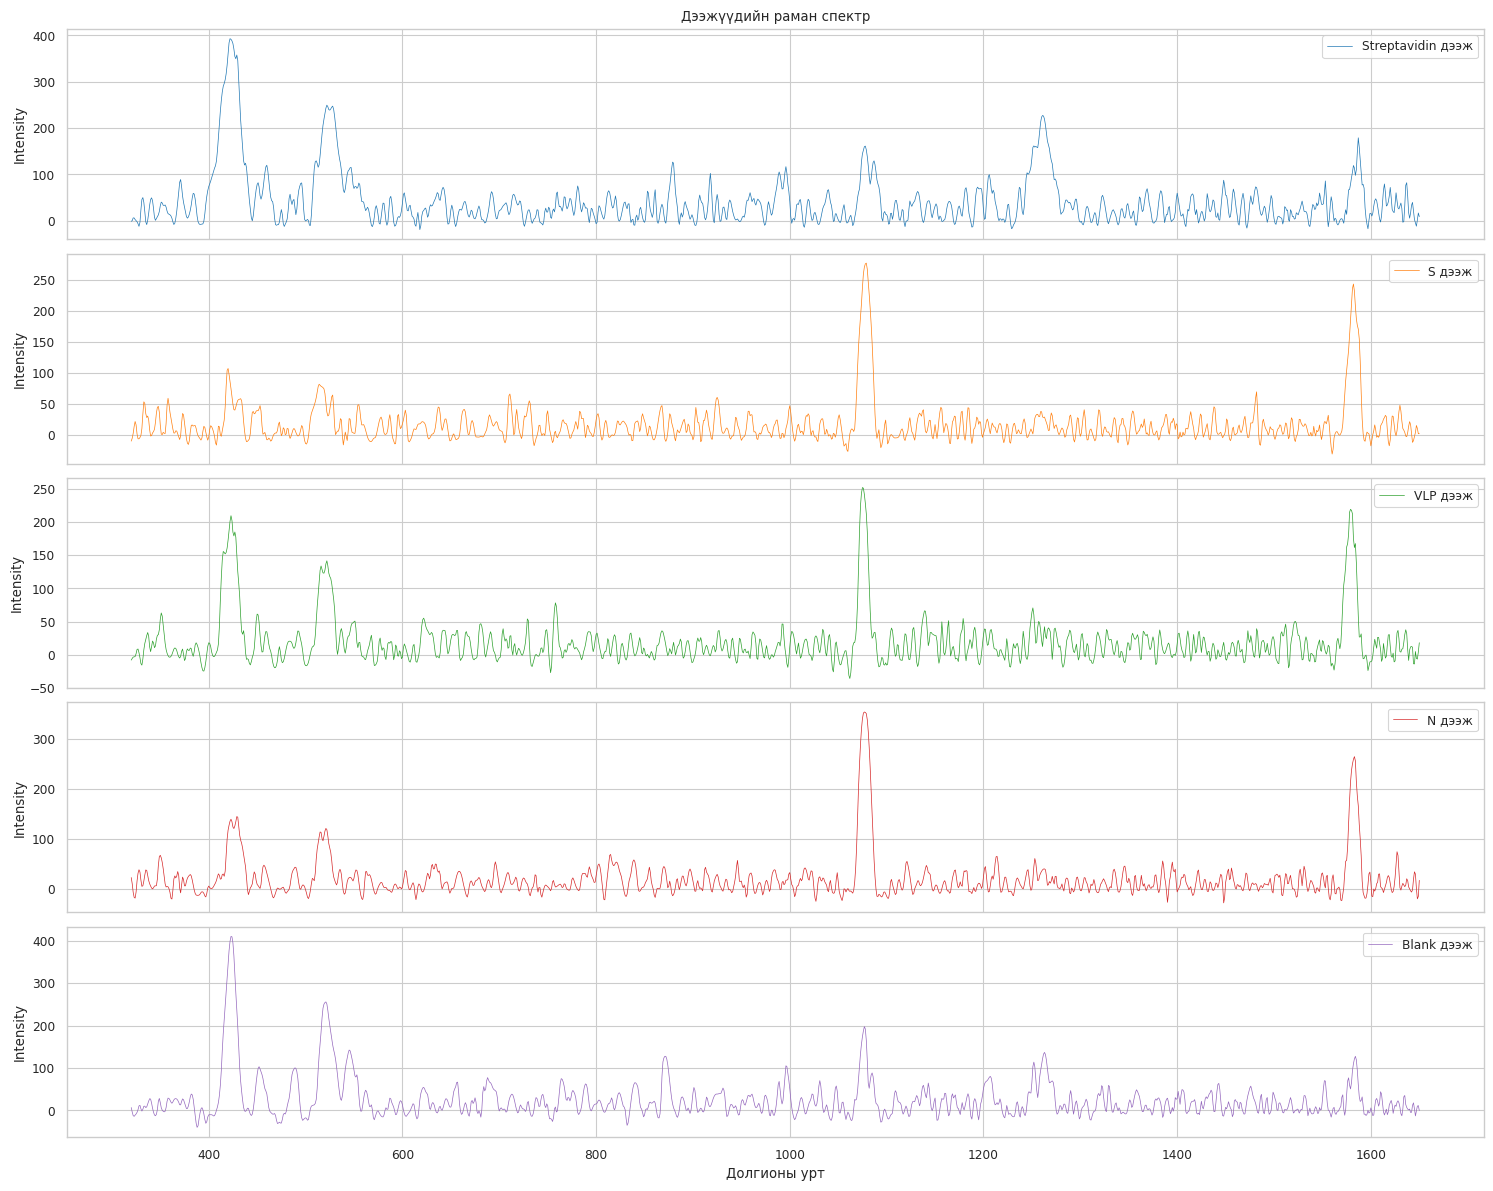

In [18]:
fig, axs = plt.subplots(len(selected_intensity), 1, sharex=True, figsize=(15, 12))

for i in range(len(selected_intensity)):
    axs[i].plot(wavelength, selected_intensity[i], linewidth=0.5, label=f'{unique_diagnostic[i]} дээж', color=custom_colors[i])
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Дээжүүдийн раман спектр')
# axs[0].set_xticks(custom_xticks)
axs[len(selected_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

### Multi Class Mean Spectrum

In [19]:
multiclass_mean_spectrum = data.drop(['COVID-19_Status'], axis=1).groupby('Diagnostic').mean()

avg_intensity = multiclass_mean_spectrum.values
y_avg = multiclass_mean_spectrum.index.tolist()

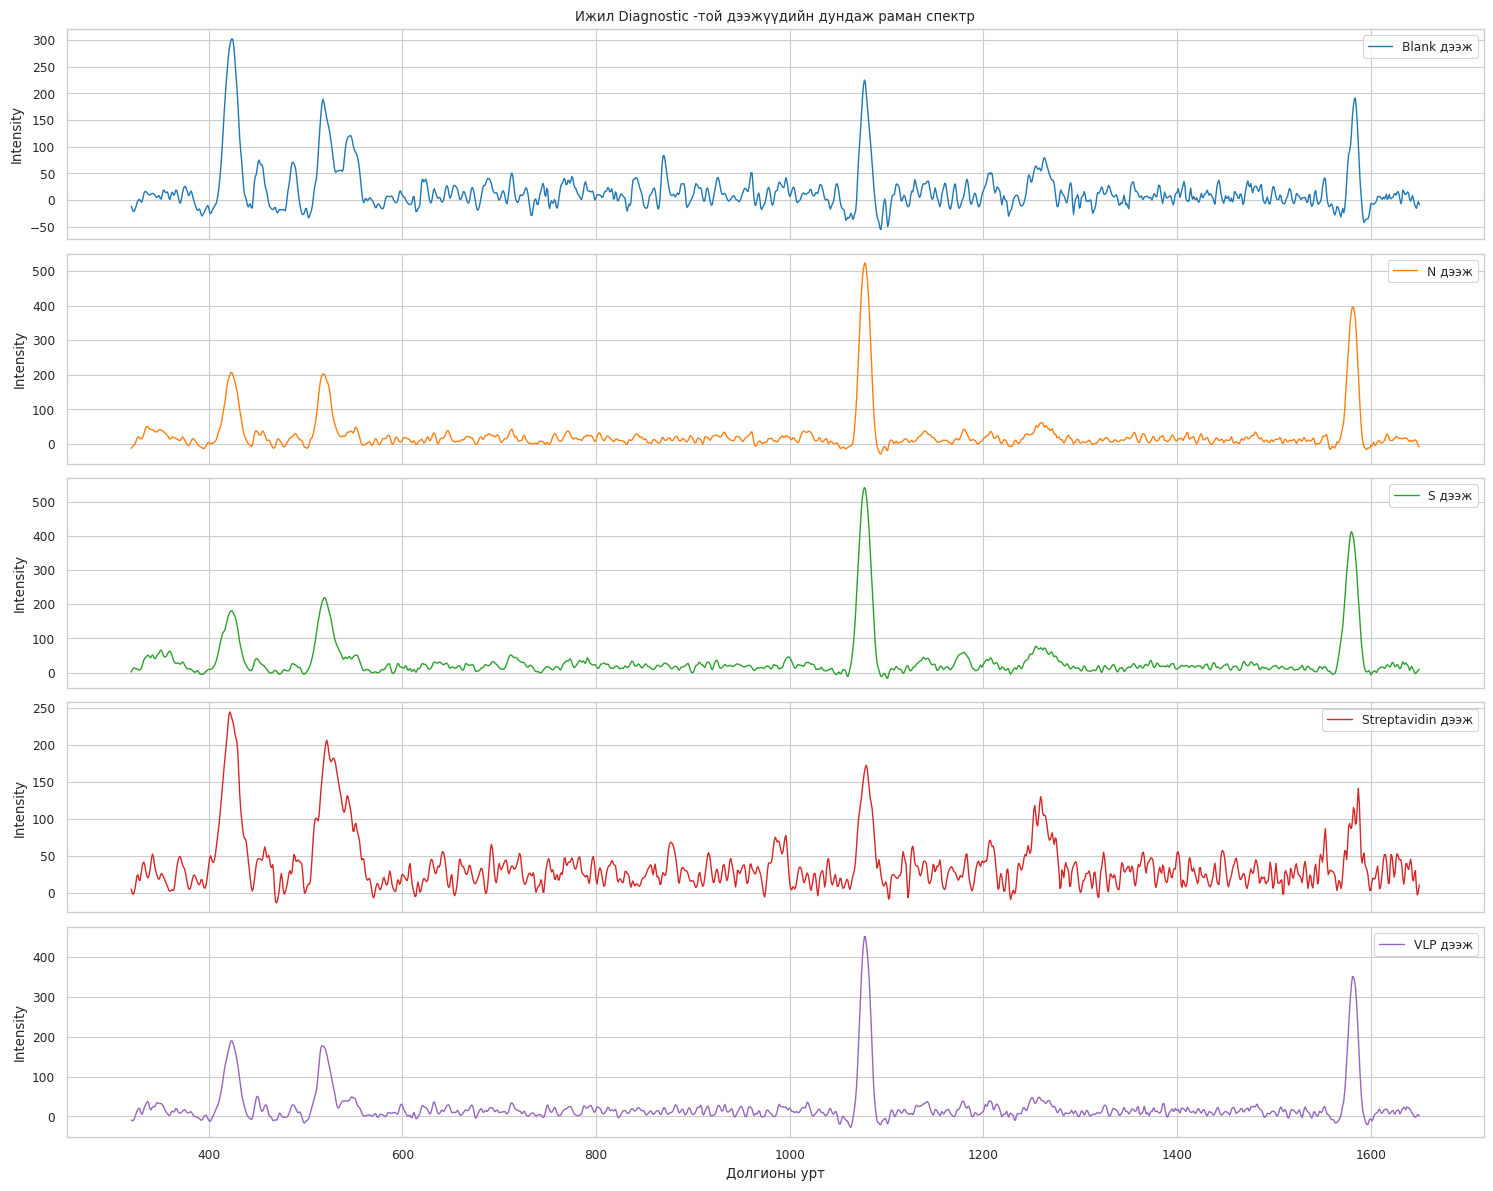

In [47]:

fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(15, 12))

for i in range(len(avg_intensity)):
    axs[i].plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж', color=custom_colors[i])
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title("Ижил Diagnostic -той дээжүүдийн дундаж раман спектр")
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

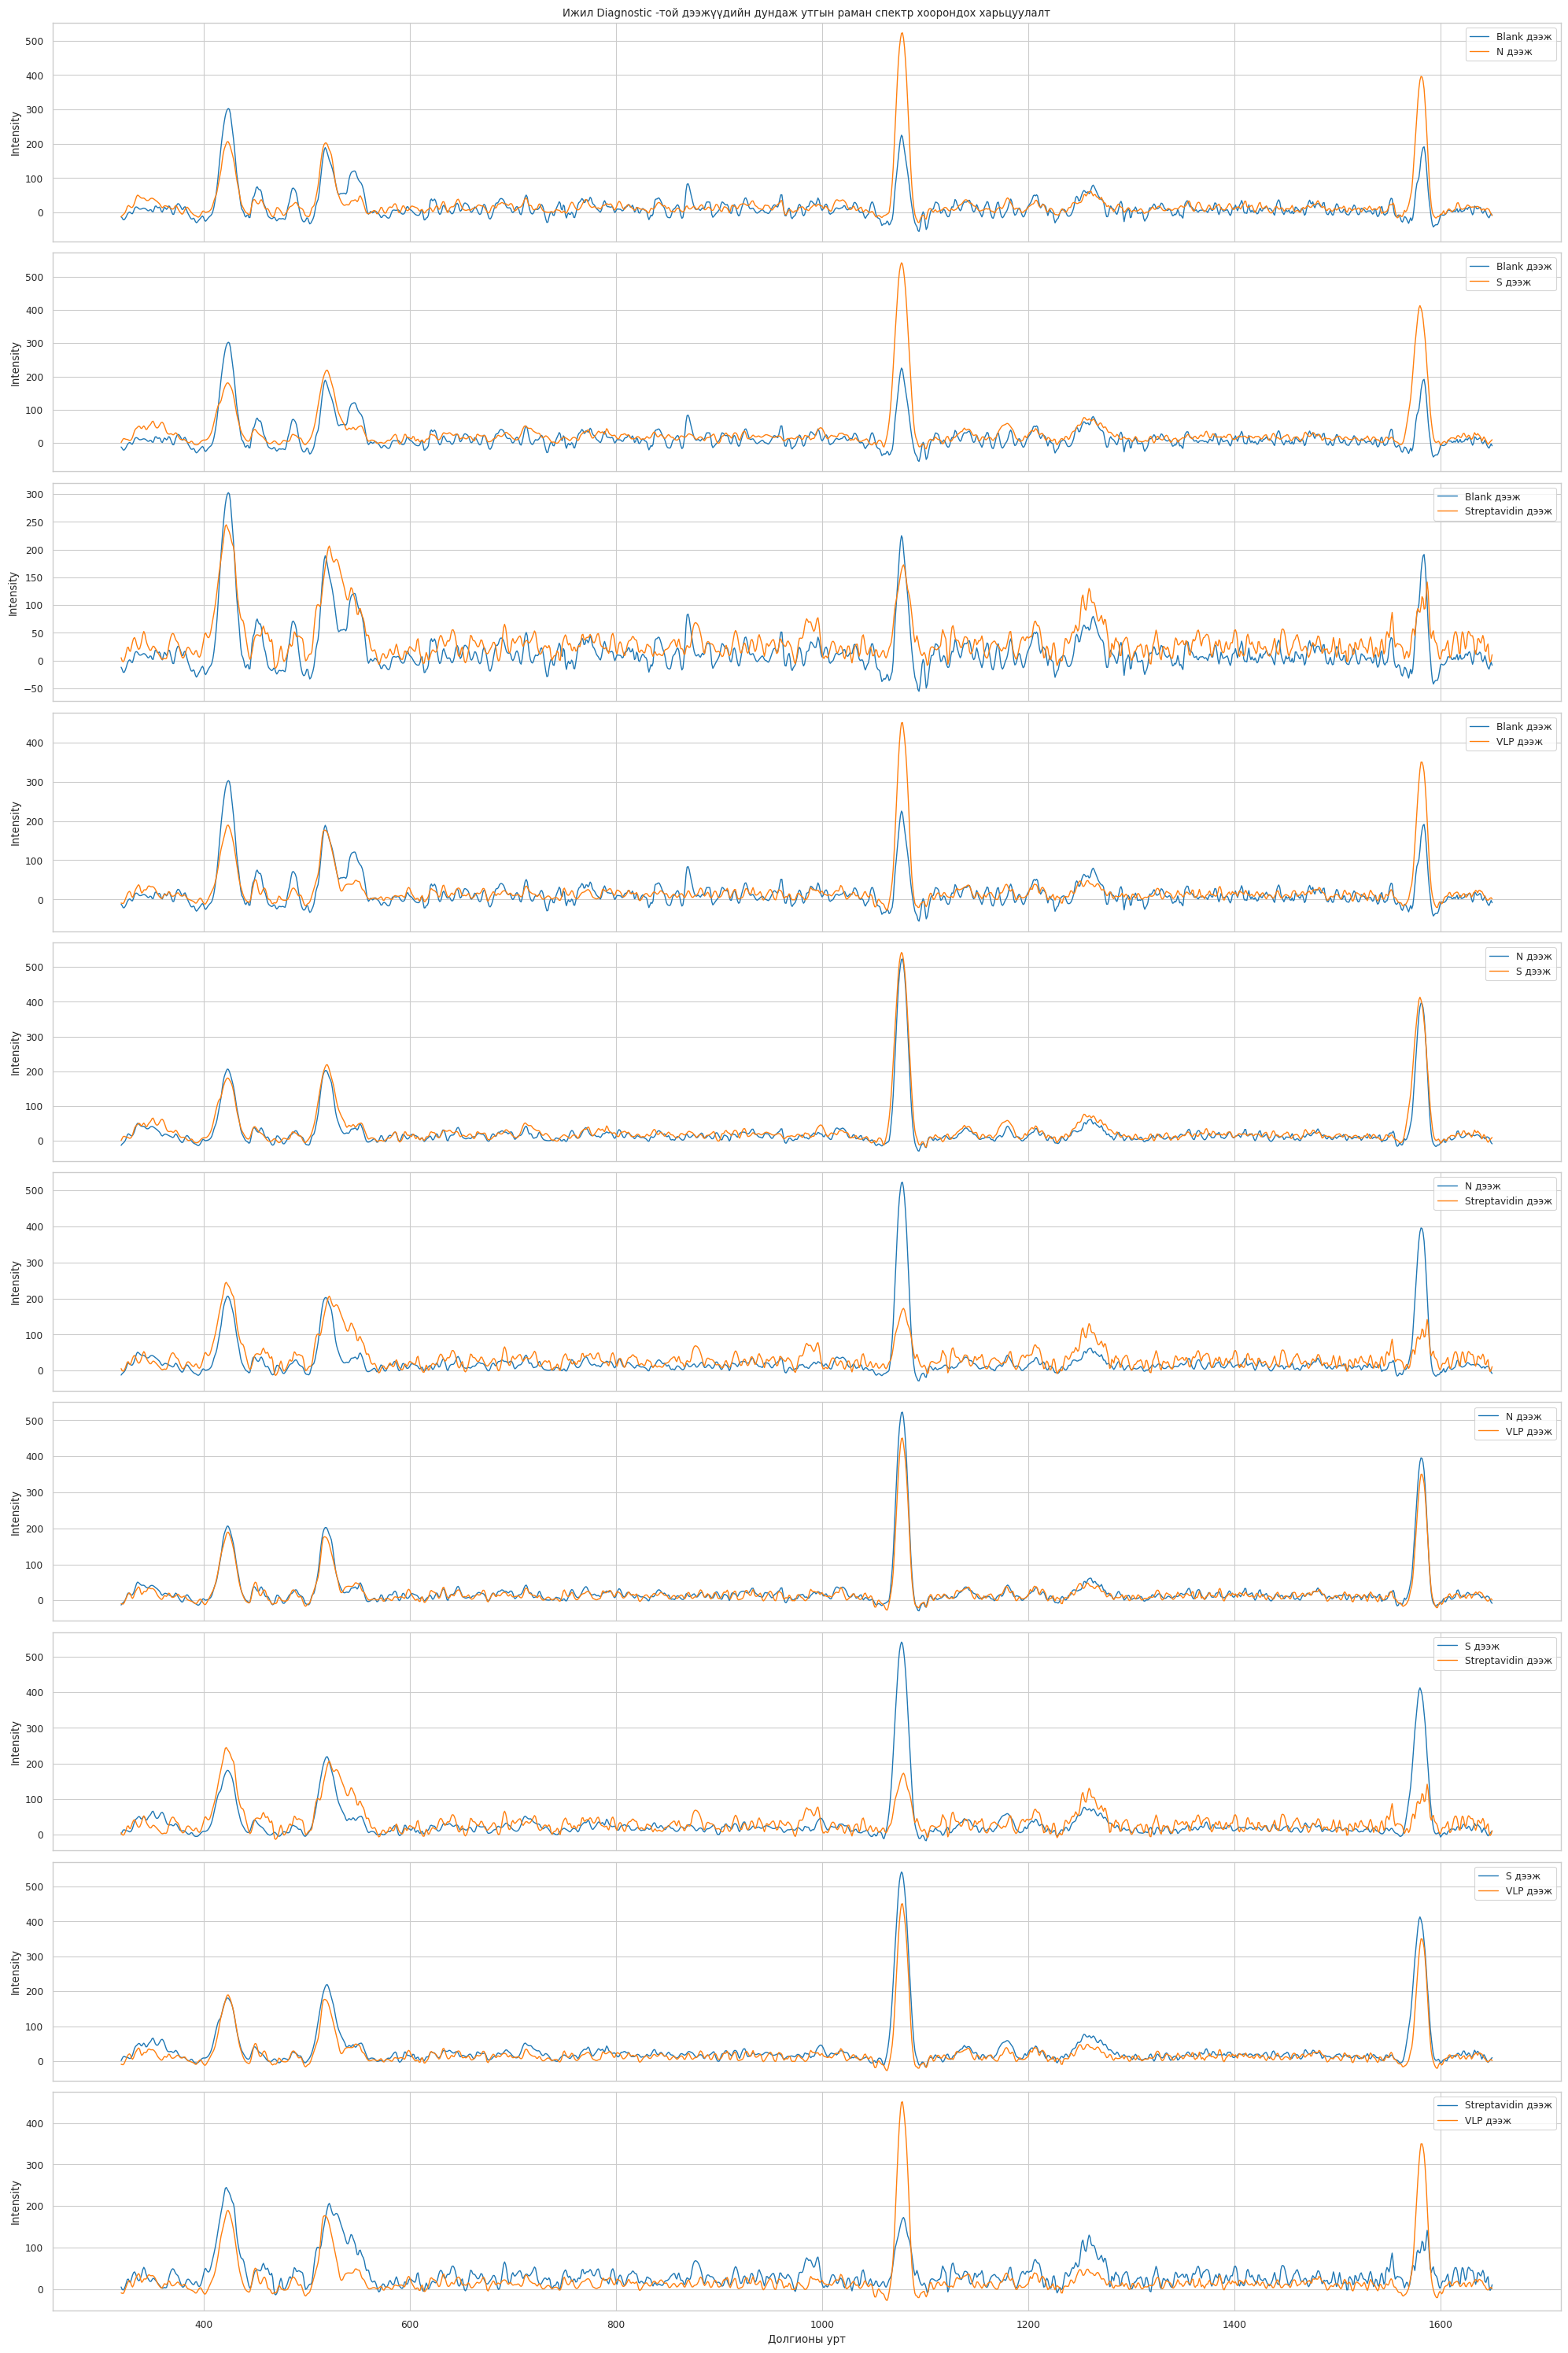

In [49]:
fig, axs = plt.subplots(10, 1, sharex=True, figsize=(20, 30))

id = 0
for i in range(len(avg_intensity) - 1):
    for j in range(i + 1, len(avg_intensity)):
        axs[id].plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж')
        axs[id].plot(wavelength, avg_intensity[j], label=f'{y_avg[j]} дээж')
        axs[id].set_ylabel('Intensity')
        axs[id].legend()
        id += 1

axs[0].set_title('Ижил Diagnostic -той дээжүүдийн дундаж утгын раман спектр хоорондох харьцуулалт')
# axs[0].set_xticks(custom_xticks)
plt.xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

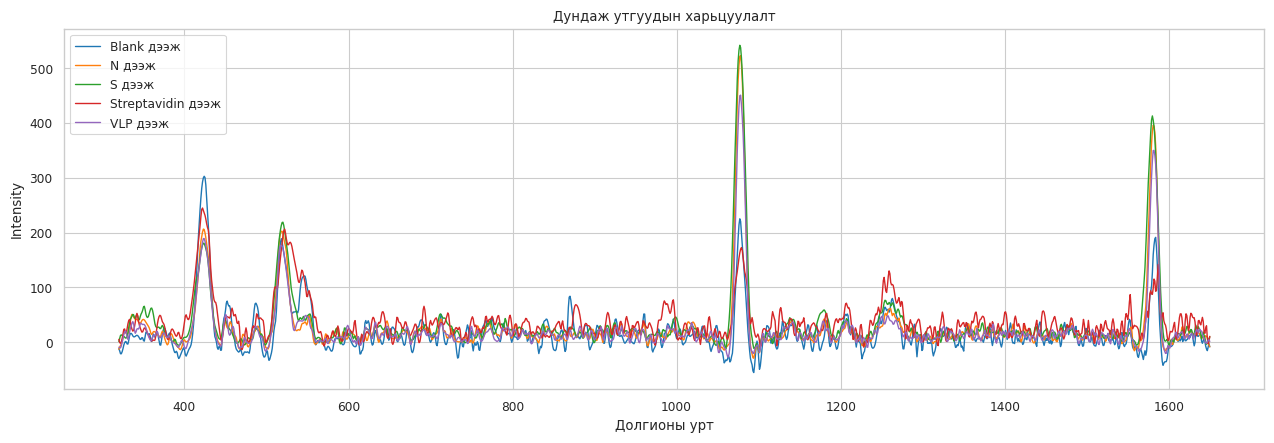

In [60]:
fig, ax = plt.subplots()

for i in range(len(avg_intensity)):
    ax.plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт')
# ax.set_xticks(custom_xticks)
ax.legend()

plt.show()

#### Find peaks

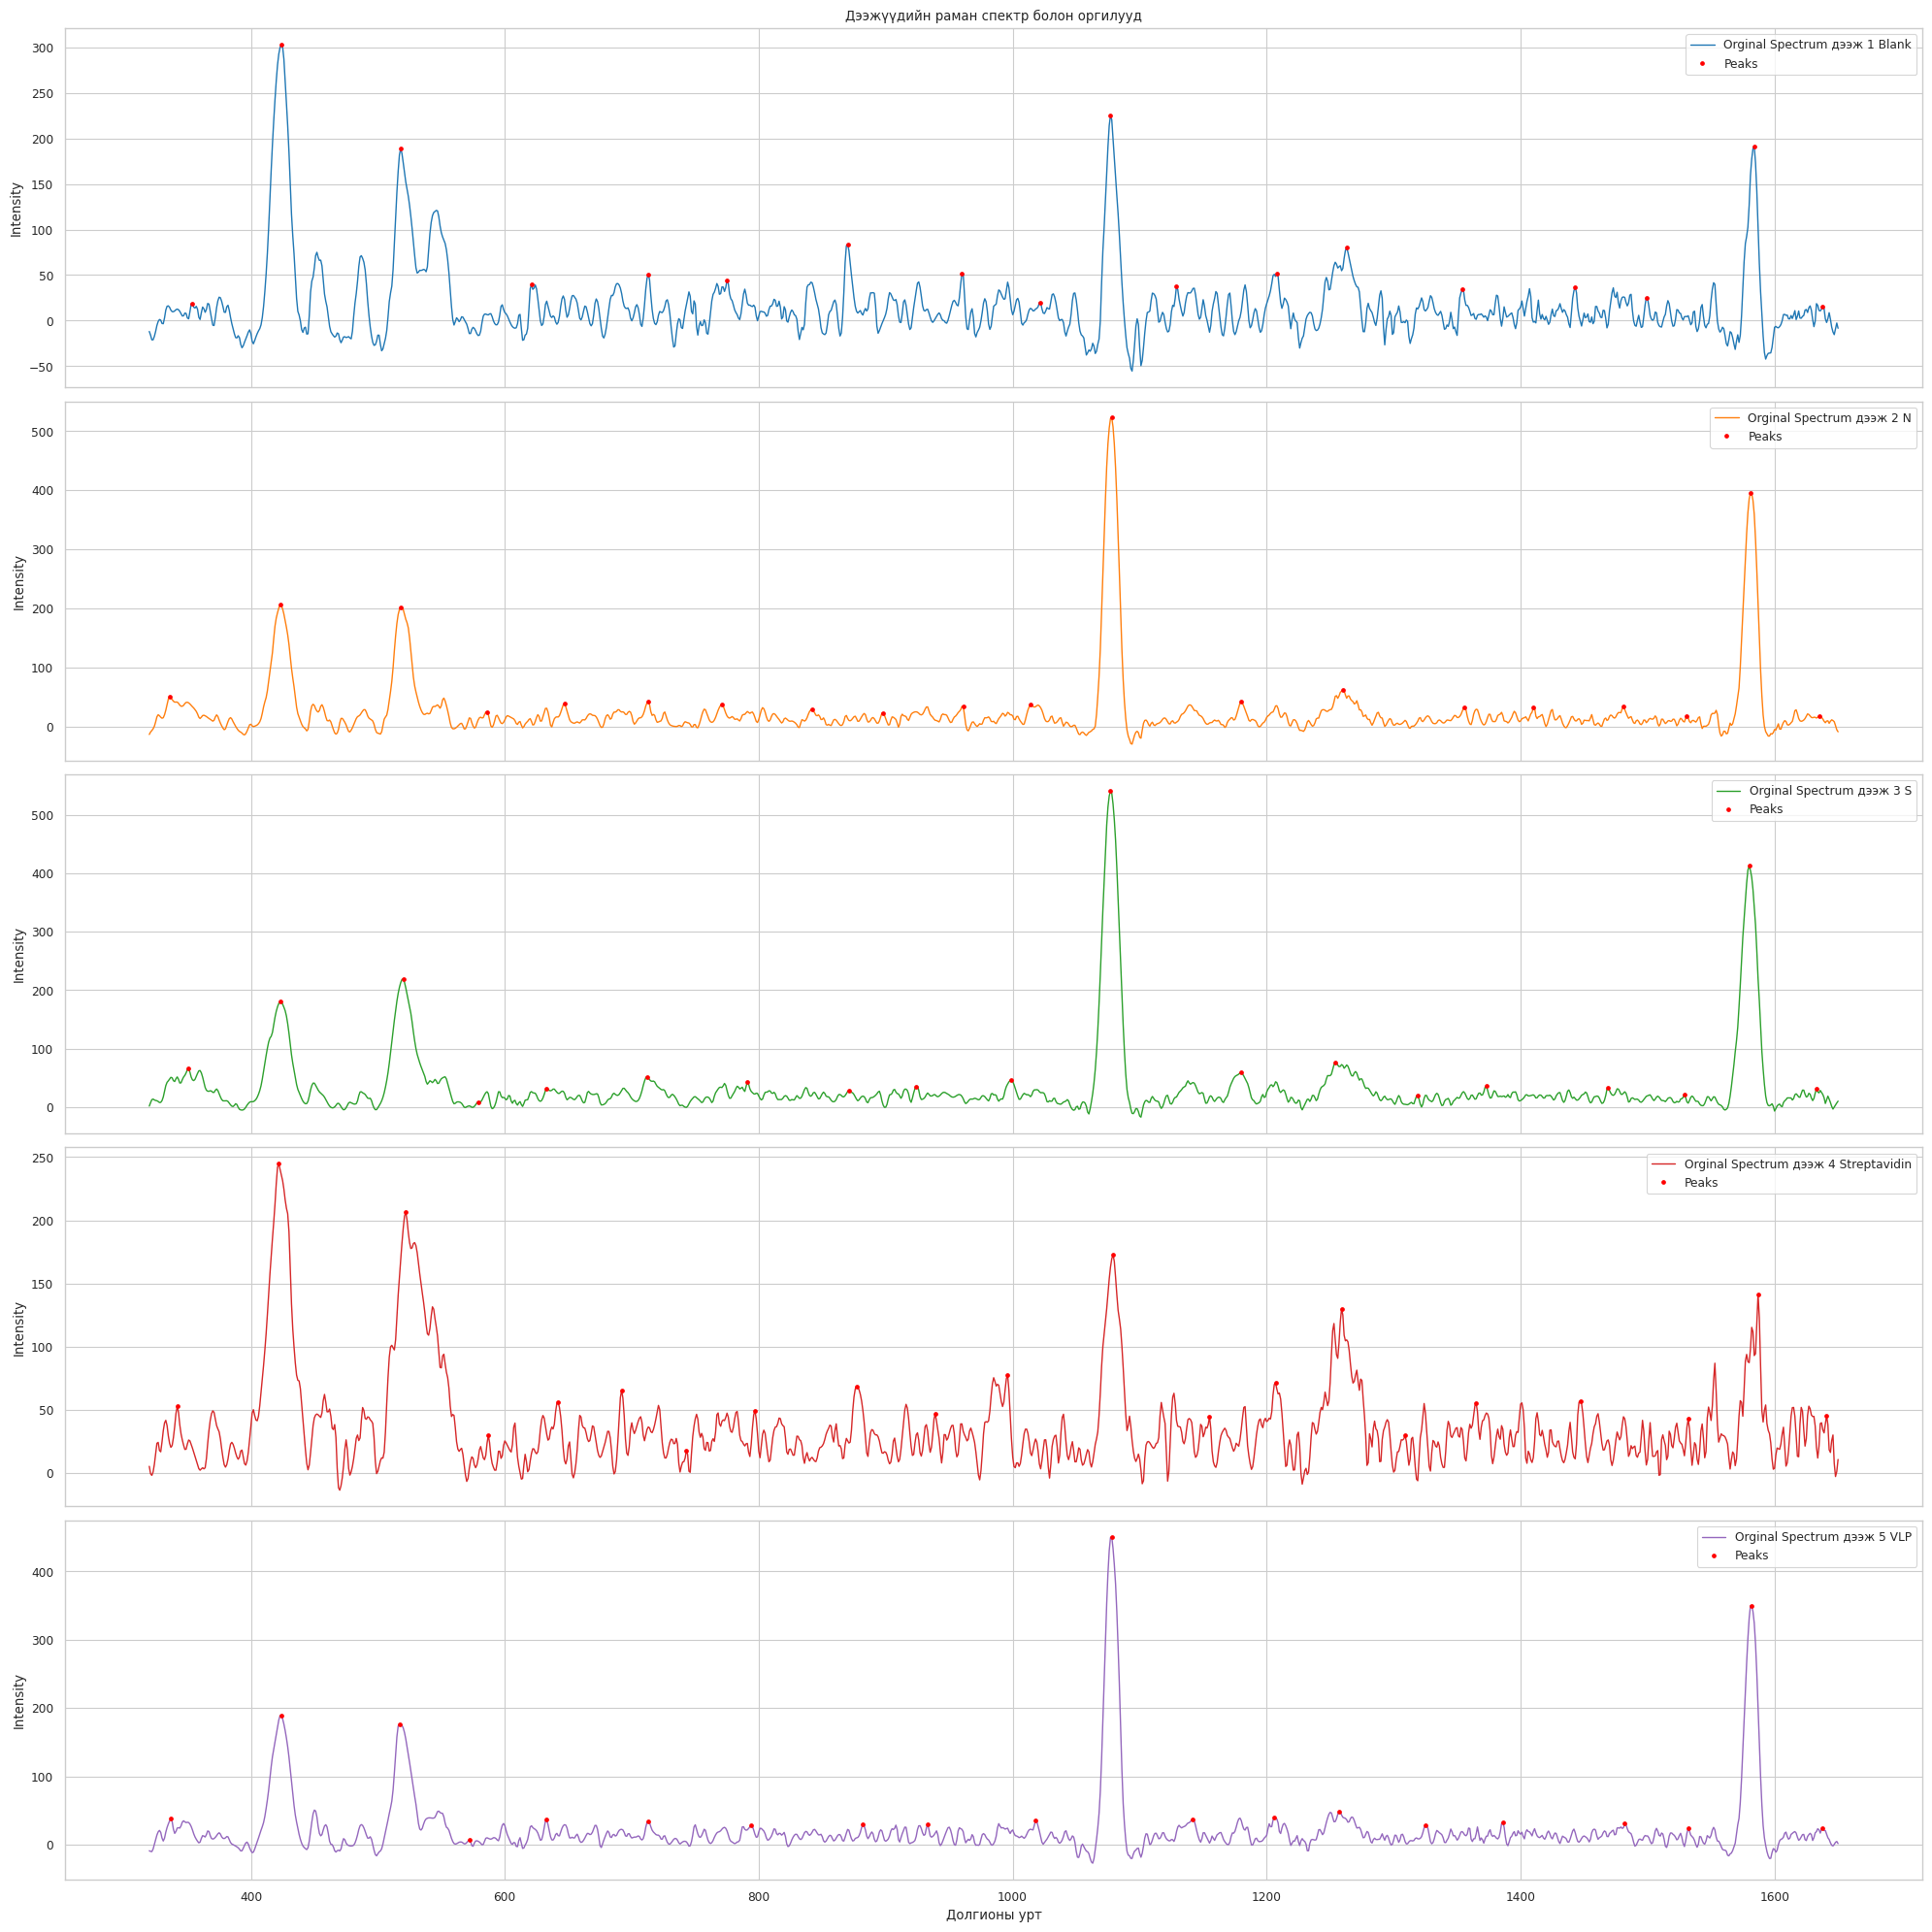

In [40]:
fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(20, 20))

for i in range(len(avg_intensity)):
    tmp = avg_intensity[i]
    peaks, _ = find_peaks(tmp, height=0.1, distance=50)
    
    axs[i].plot(wavelength, tmp, color=custom_colors[i], label=f'Orginal Spectrum дээж {i + 1} {y_avg[i]}')
    axs[i].plot(wavelength[peaks], tmp[peaks], 'r.', label='Peaks')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Дээжүүдийн раман спектр болон оргилууд')
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

#### Smooth the spectrum using Savitzky-Golay filter

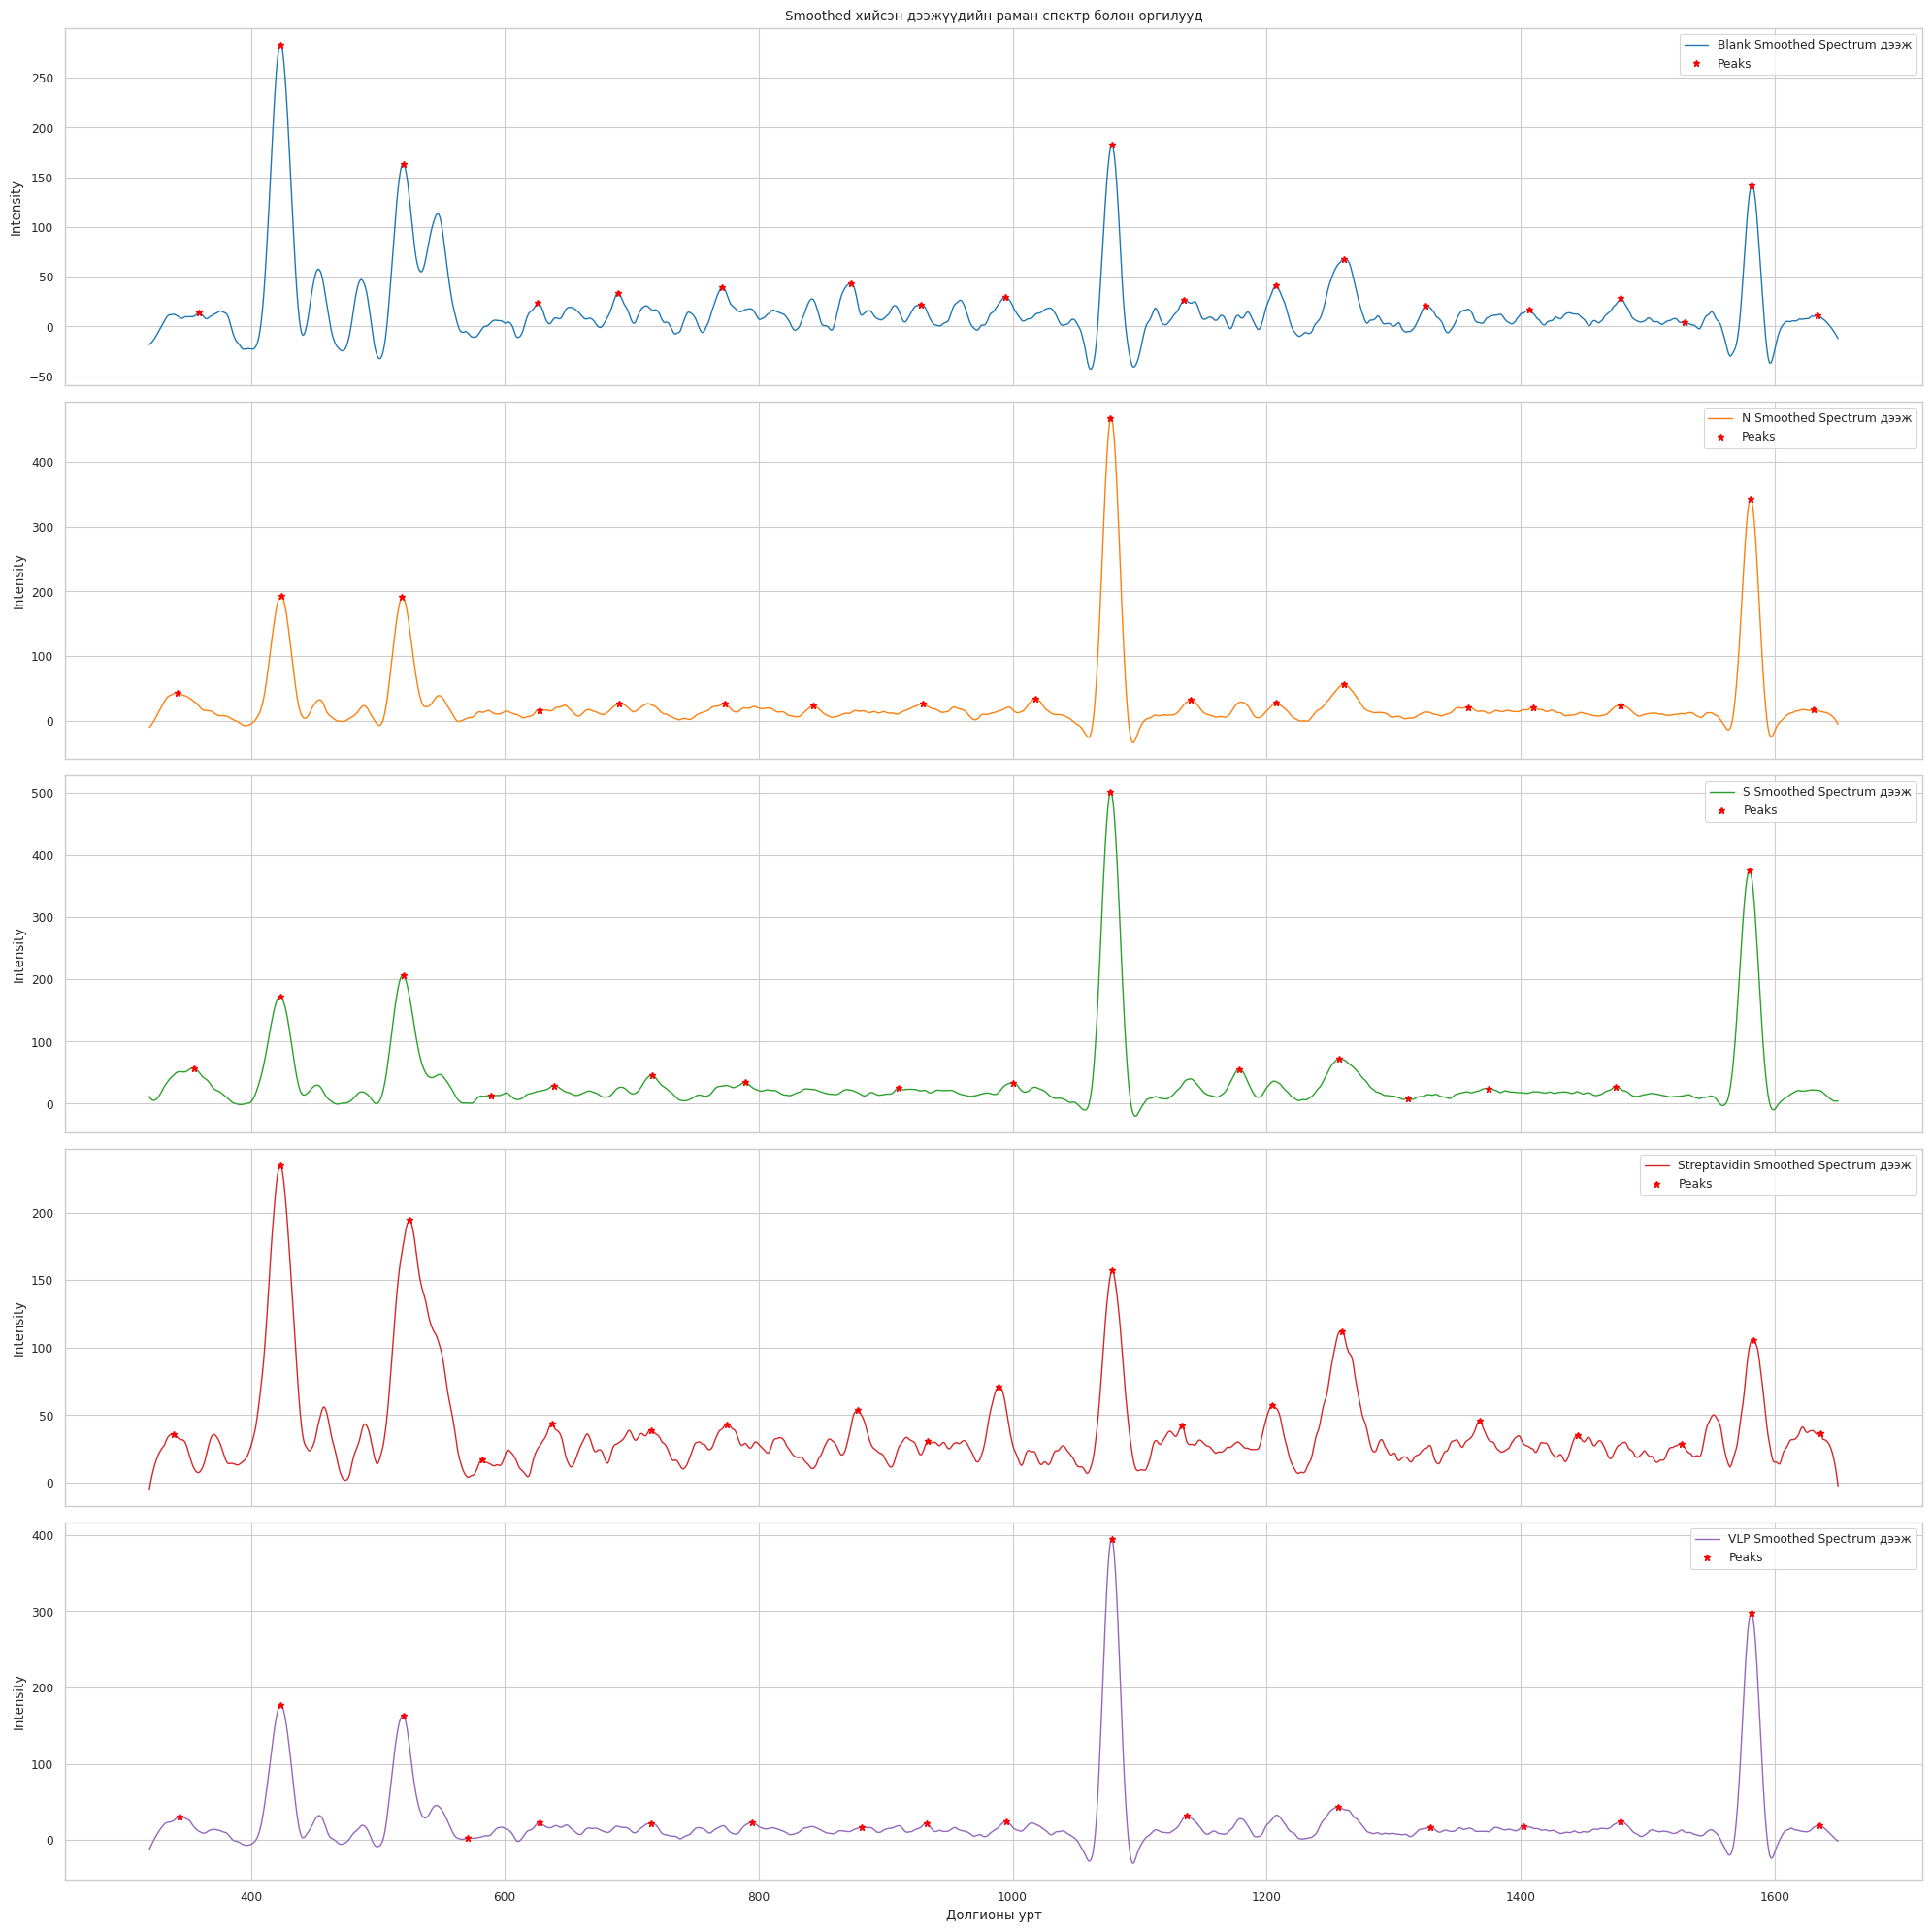

In [50]:
fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(20, 20))

for i in range(len(avg_intensity)):
    smoothed_spectrum = savgol_filter(avg_intensity[i], window_length=25, polyorder=3)
    peaks, _ = find_peaks(smoothed_spectrum, height=0.1, distance=50)
    
    axs[i].plot(wavelength, smoothed_spectrum, label=f'{y_avg[i]} Smoothed Spectrum дээж', color=custom_colors[i])
    axs[i].plot(wavelength[peaks], smoothed_spectrum[peaks], 'r*', label='Peaks')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Smoothed хийсэн дээжүүдийн раман спектр болон оргилууд')
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

### Binary Mean Spectrum

#### Extract spectrum

In [25]:
binary_mean_spectrum = data.drop('Diagnostic', axis=1).groupby('COVID-19_Status').mean()

mean_intensity = binary_mean_spectrum.values
y_mean = binary_mean_spectrum.index.tolist()

#### Plotting smoothed spectrum

0    1    2    3    4    5    6    7    8    9     10    11    12  \
Peaks  372  423  522  584  638  690  772  875  931  991  1078  1134  1207   

         13    14    15    16    17    18  
Peaks  1260  1368  1421  1480  1582  1635

0    1    2    3    4    5    6    7    8     9     10    11    12  \
Peaks  343  424  520  587  640  714  773  843  930  1017  1078  1179  1258   

         13    14    15    16    17  
Peaks  1359  1409  1478  1581  1632

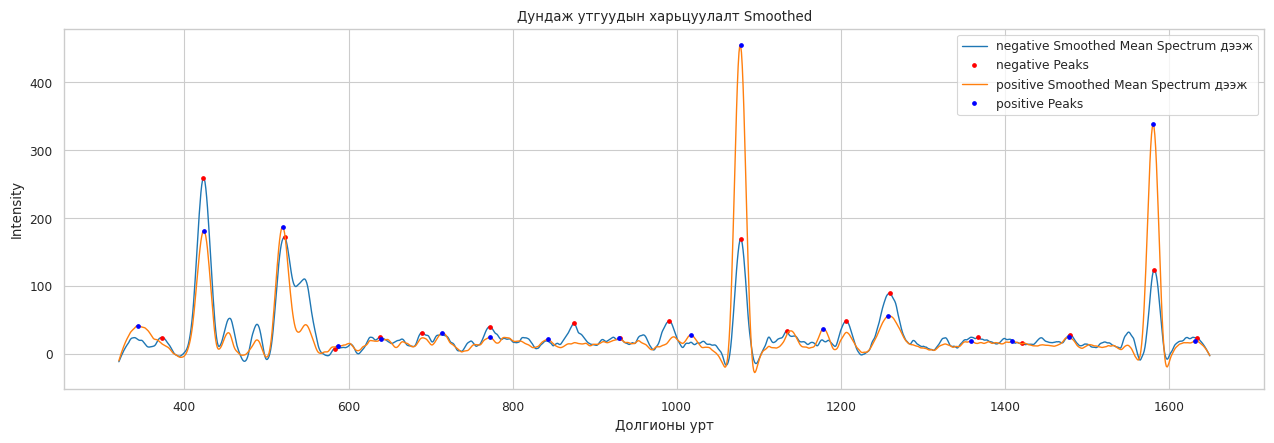

In [61]:
fig, ax = plt.subplots()

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    smoothed_mean_spectrum = savgol_filter(mean_intensity[i], window_length=25, polyorder=2)
    peaks, _ = find_peaks(smoothed_mean_spectrum, height=0.1, distance=50)
    display(pd.DataFrame({'Peaks' : peaks + 320}).T)
    ax.plot(wavelength, smoothed_mean_spectrum, label=f'{y_mean[i]} Smoothed Mean Spectrum дээж')
    ax.plot(wavelength[peaks], smoothed_mean_spectrum[peaks], peak_color[i], label=f'{y_mean[i]} Peaks')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт Smoothed')
# ax.set_xticks(custom_xticks)
plt.grid(True)
ax.legend()

plt.show()

#### Plotting orignal spectrum

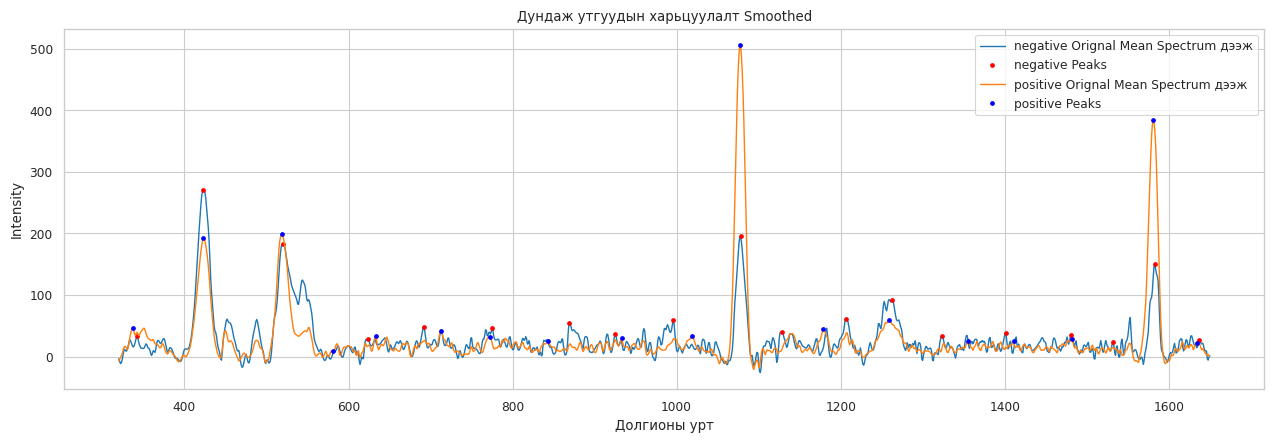

In [62]:
fig, ax = plt.subplots()

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    tmp = mean_intensity[i]
    peaks, _ = find_peaks(tmp, height=0.1, distance=50)
    # display(pd.DataFrame({'Peaks' : peaks + 320}).T)
    # display(pd.DataFrame(tmp[peaks]).T)
    ax.plot(wavelength, tmp, label=f'{y_mean[i]} Orignal Mean Spectrum дээж')
    ax.plot(wavelength[peaks], tmp[peaks], peak_color[i], label=f'{y_mean[i]} Peaks')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт Smoothed')
# ax.set_xticks(custom_xticks)
plt.grid(True)
ax.legend()

plt.show()

#### Baseline correction

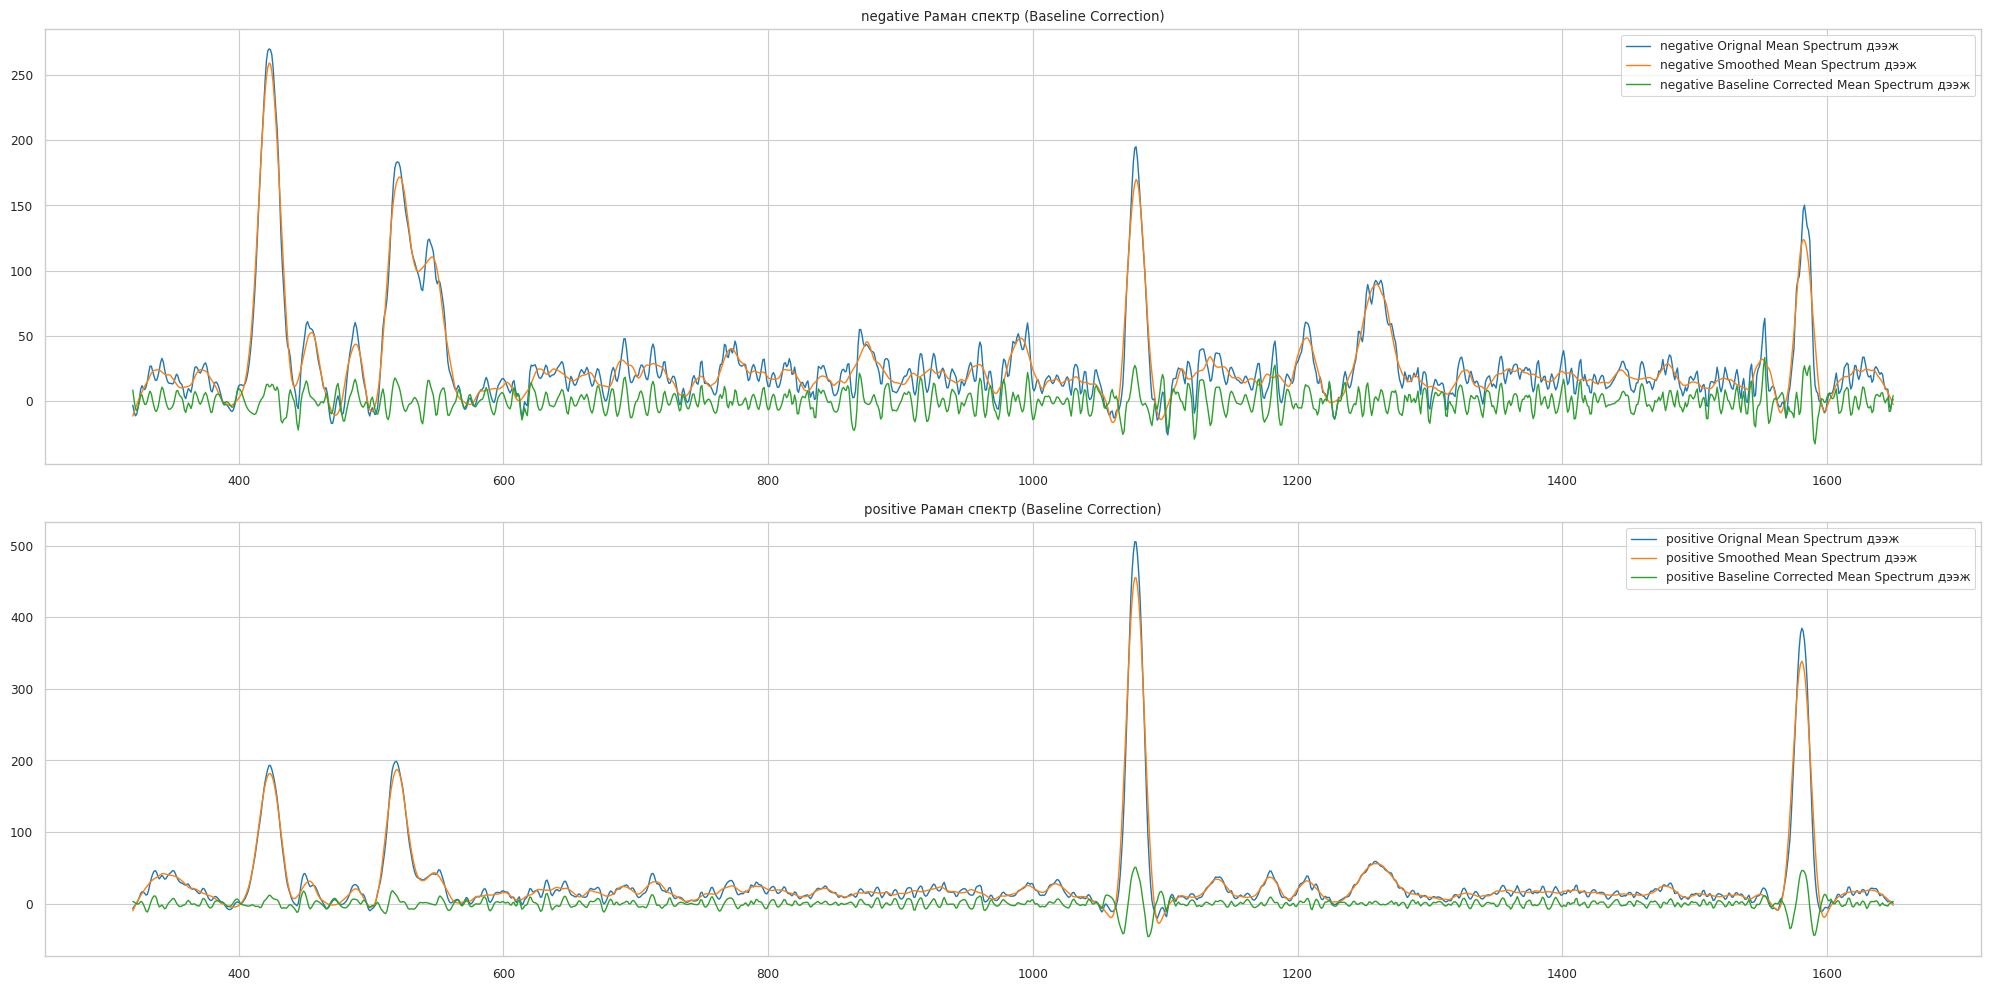

In [28]:
fig, axs = plt.subplots(len(binary_mean_spectrum), 1, figsize=(20, 10))

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    tmp_intensity = mean_intensity[i]
    smoothed_mean_spectrum = savgol_filter(tmp_intensity, window_length=25, polyorder=2)
    baseline_corrected_mean_spectrum = tmp_intensity - smoothed_mean_spectrum

    axs[i].plot(wavelength, tmp_intensity, label=f'{y_mean[i]} Orignal Mean Spectrum дээж')
    axs[i].plot(wavelength, smoothed_mean_spectrum, label=f'{y_mean[i]} Smoothed Mean Spectrum дээж')
    axs[i].plot(wavelength, baseline_corrected_mean_spectrum, label=f'{y_mean[i]} Baseline Corrected Mean Spectrum дээж')
    
    axs[i].set_title('{} Раман спектр (Baseline Correction)'.format(y_mean[i]))
    axs[i].legend()
    axs[i].grid(True)

ax.set_ylabel('Intensity')
ax.set_xlabel('Долгионы урт')
# ax.set_xticks(custom_xticks)
plt.tight_layout()
plt.show()

### Zoom in

#### Binary Mean Spectrum seperate display

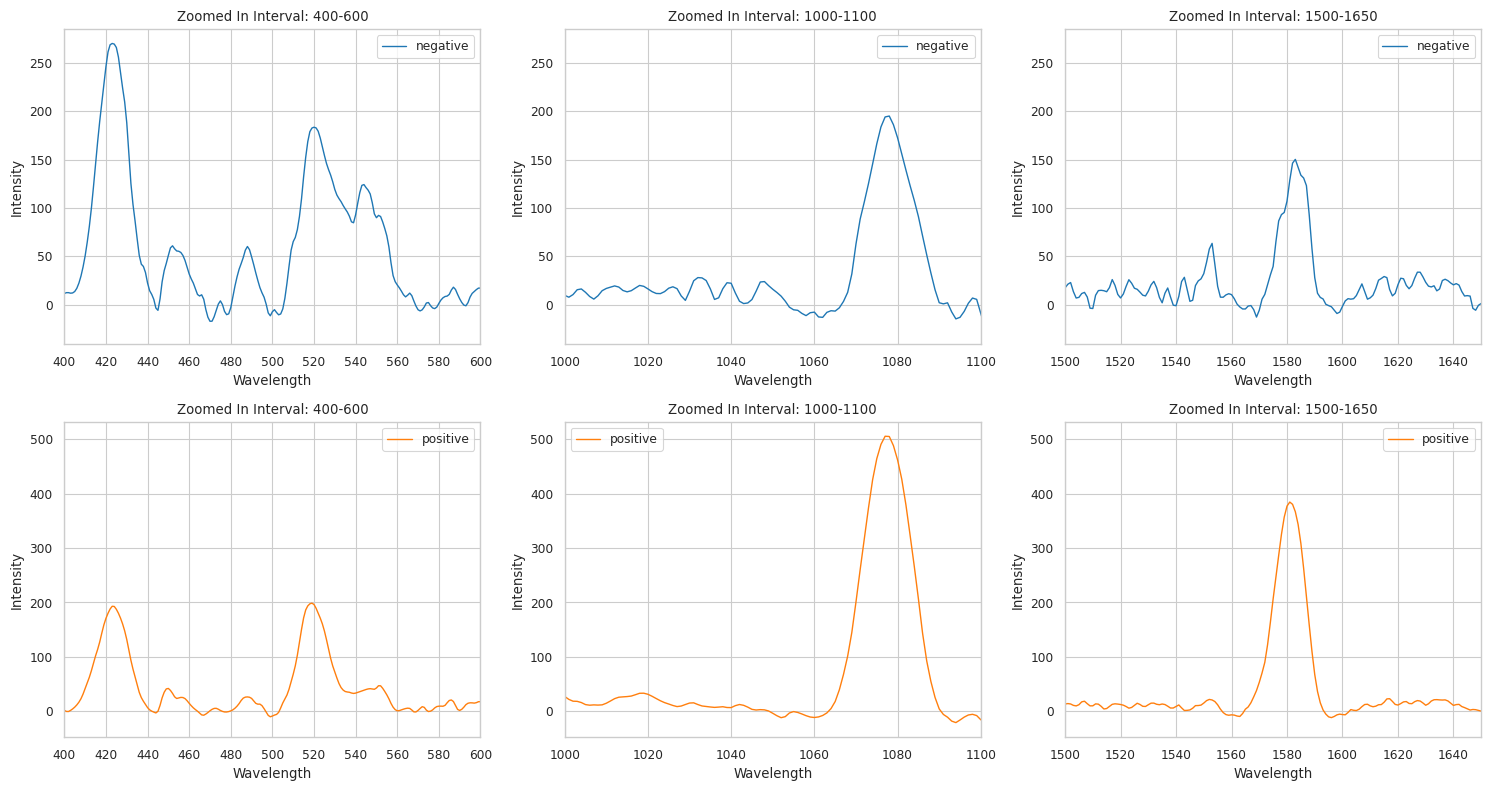

In [63]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(len(binary_mean_spectrum), len(intervals), figsize=(15, 8))

for row in range(len(binary_mean_spectrum)):
    for col, (start, end) in enumerate(intervals):
        # Set x-axis limits for the current interval
        axs[row, col].set_xlim(start, end)
        
        # Set tick positions and labels for the current interval
        tick_positions = np.arange(start, end + 1, step=20)
        axs[row, col].set_xticks(tick_positions)
        
        axs[row, col].set_xlabel('Wavelength')
        axs[row, col].set_ylabel('Intensity')
        axs[row, col].set_title(f'Zoomed In Interval: {start}-{end}')

        axs[row, col].plot(wavelength, mean_intensity[row], color=custom_colors[row], label='{}'.format(y_mean[row]))
        axs[row, col].legend()

plt.tight_layout()
plt.show()

#### One plot

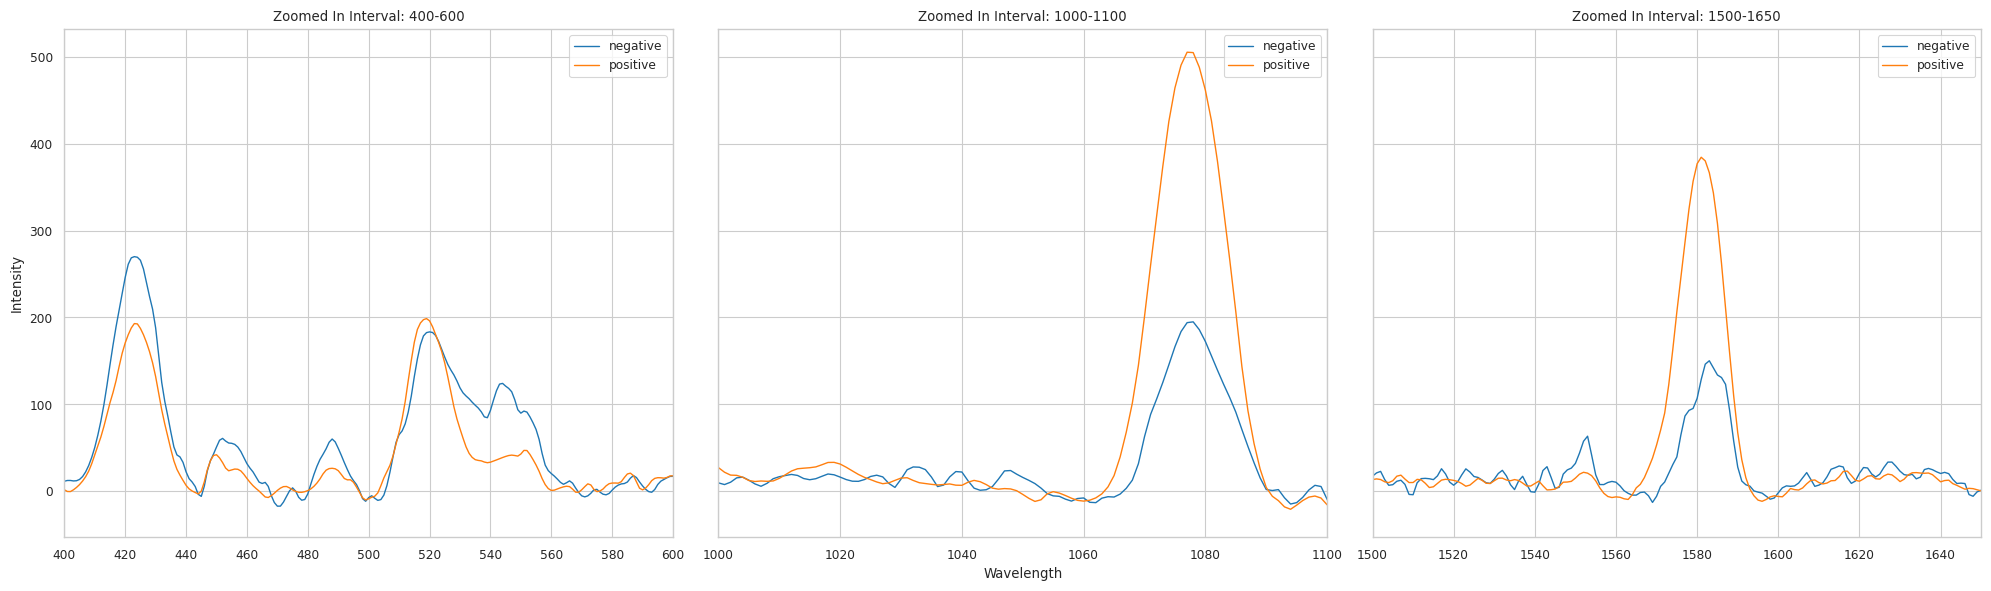

In [65]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(1, len(intervals), sharey=True)

for i, (start, end) in enumerate(intervals):
    # Set x-axis limits for the current interval
    axs[i].set_xlim(start, end)
    
    # Set tick positions and labels for the current interval
    tick_positions = np.arange(start, end + 1, step=20)
    axs[i].set_xticks(tick_positions)

    axs[i].set_title(f'Zoomed In Interval: {start}-{end}')

    for j in range(len(binary_mean_spectrum)):
        axs[i].plot(wavelength, mean_intensity[j], label='{}'.format(y_mean[j]))
    
    axs[i].legend()
    axs[i].grid(True) 

axs[0].set_ylabel('Intensity')
axs[1].set_xlabel('Wavelength')

plt.tight_layout()
plt.show()

#### Multi class one plot

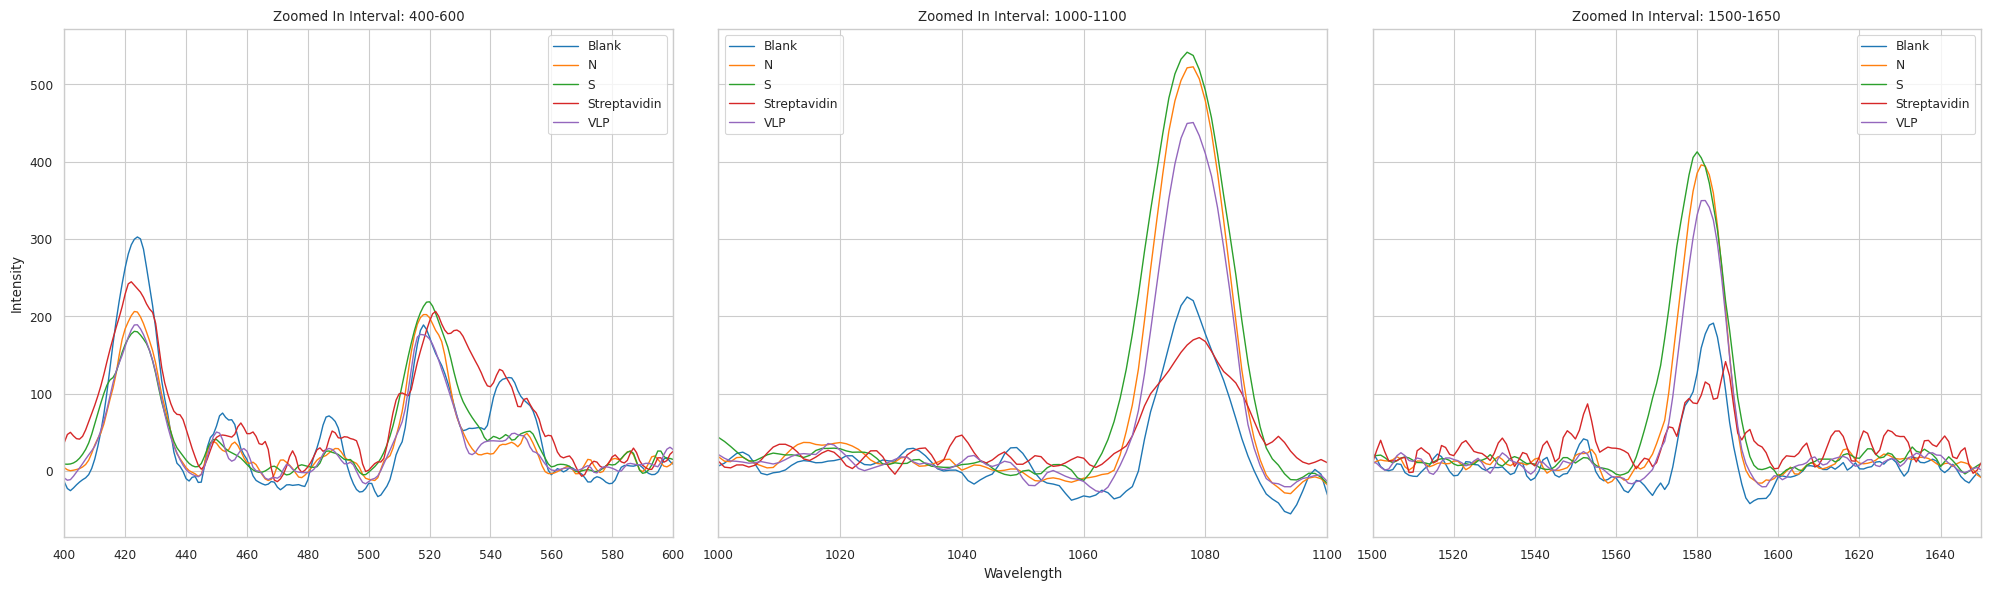

In [67]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(1, len(intervals), sharey=True)

for i, (start, end) in enumerate(intervals):
    # Set x-axis limits for the current interval
    axs[i].set_xlim(start, end)
    
    # Set tick positions and labels for the current interval
    tick_positions = np.arange(start, end + 1, step=20)
    axs[i].set_xticks(tick_positions)

    axs[i].set_title(f'Zoomed In Interval: {start}-{end}')

    for j in range(len(multiclass_mean_spectrum)):
        axs[i].plot(wavelength, avg_intensity[j], label='{}'.format(y_avg[j]))
    
    axs[i].legend()
    axs[i].grid(True) 

axs[0].set_ylabel('Intensity')
axs[1].set_xlabel('Wavelength')
plt.tight_layout()
plt.show()

## Model training

### Binary Clasification

In [ ]:
label_mapping = {'negative': 0, 'positive': 1}
y_covid_status_numeric = y_covid_status.map(label_mapping)


X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status_numeric, test_size=0.2, random_state=42)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode the binary labels to numerical values (1 for 'positive', 0 for 'negative')
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Define a simple feedforward neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy*100:.2f}%')


Epoch 1/10
1/1 [==============================] - 0s 286ms/step - loss: 0.8973 - accuracy: 0.4643
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.9286
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Test loss: 0.3629, Test accuracy: 85.

In [33]:
# Define your CNN model
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
1/1 [==============================] - 0s 419ms/step - loss: 0.6196 - accuracy: 0.7857 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 25ms/step - loss: 0.7631 - accuracy: 0.7857 - val_loss: 0.2646 - val_accuracy: 0.8571
Epoch 3/10
1/1 [==============================] - 0s 27ms/step - loss: 0.1439 - accuracy: 0.9286 - val_loss: 0.7194 - val_accuracy: 0.7143
Epoch 4/10
1/1 [==============================] - 0s 25ms/step - loss: 0.2472 - accuracy: 0.8929 - val_loss: 0.2960 - val_accuracy: 0.8571
Epoch 5/10
1/1 [==============================] - 0s 22ms/step - loss: 0.0381 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 21ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 8/10
1/1 [==========

Epoch 1/10
1/1 [==============================] - 1s 566ms/step - loss: 0.7550 - accuracy: 0.3636 - val_loss: 1.7704 - val_accuracy: 0.8333
Epoch 2/10
1/1 [==============================] - 0s 23ms/step - loss: 2.7979 - accuracy: 0.7727 - val_loss: 0.8854 - val_accuracy: 0.8333
Epoch 3/10
1/1 [==============================] - 0s 25ms/step - loss: 1.0550 - accuracy: 0.7727 - val_loss: 0.1976 - val_accuracy: 0.8333
Epoch 4/10
1/1 [==============================] - 0s 24ms/step - loss: 0.1954 - accuracy: 0.9545 - val_loss: 0.6133 - val_accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 0.3906 - accuracy: 0.9091 - val_loss: 0.7248 - val_accuracy: 0.1667
Epoch 6/10
1/1 [==============================] - 0s 27ms/step - loss: 0.4049 - accuracy: 0.8182 - val_loss: 0.4468 - val_accuracy: 0.8333
Epoch 7/10
1/1 [==============================] - 0s 23ms/step - loss: 0.1912 - accuracy: 0.9091 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 8/10
1/1 [==========

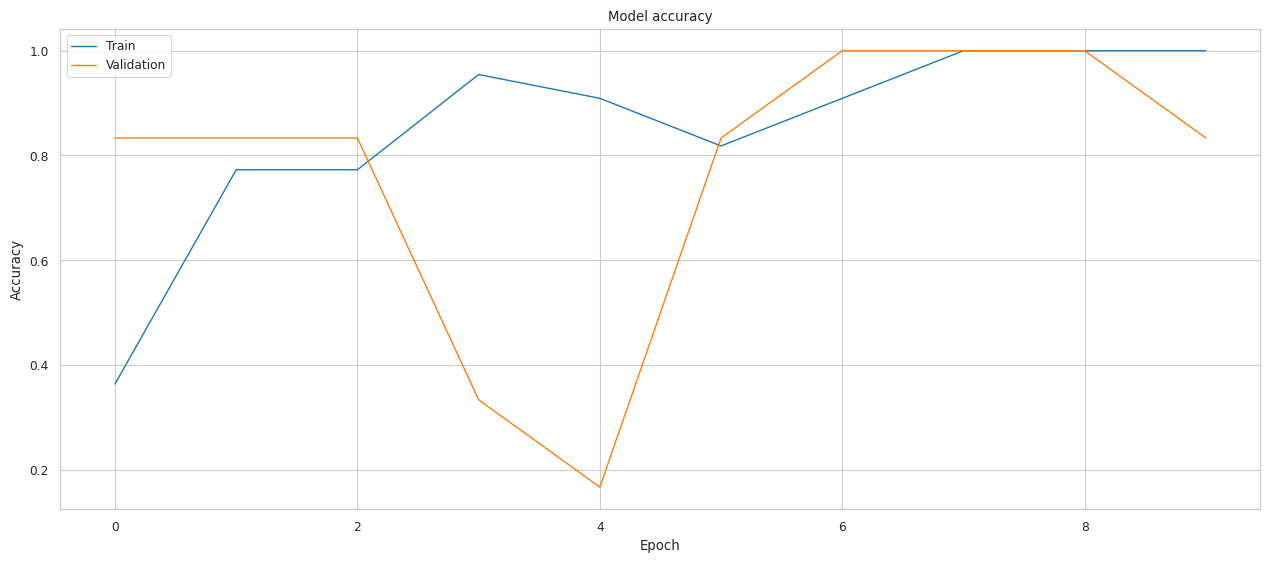

In [34]:
# Assuming you have loaded your Raman spectra data into X and labels into y

# Step 1: Data Preprocessing
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status, test_size=0.2, random_state=42)

# Standardize the input data (mean centering and scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode the binary labels to numerical values (1 for 'positive', 0 for 'negative')
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Reshape the input data for CNN (assuming each spectrum has a length of 'spectra_length')
spectra_length = X_train.shape[1]
X_train = X_train.reshape(-1, spectra_length, 1)
X_test = X_test.reshape(-1, spectra_length, 1)

# One-hot encode the binary labels (if not already done)
y_train_encoded = keras.utils.to_categorical(y_train_encoded, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test_encoded, num_classes=2)

# Step 2: Define the CNN Model
model = keras.Sequential([
    keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(spectra_length, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')  # 2 output neurons for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for binary classification
              metrics=['accuracy'])

# Step 4: Train the Model
num_epochs = 10  # Adjust as needed
batch_size = 32  # Adjust as needed
history = model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy}')

# Optionally, you can visualize training history using matplotlib
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:

# Assuming you have loaded your Raman spectra data into X and labels into y

# Step 1: Data Preprocessing (Similar to the previous example)
label_mapping = {'negative': 0, 'positive': 1}
y_covid_status_numeric = y_covid_status.map(label_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status_numeric, test_size=0.2, random_state=42)

# Standardize the input data (mean centering and scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data for ResNet (assuming each spectrum has a length of 'spectra_length')
spectra_length = X_train.shape[1]
X_train = X_train.reshape(-1, spectra_length, 1, 1)
X_test = X_test.reshape(-1, spectra_length, 1, 1)

# Encode the binary labels to numerical values (1 for 'positive', 0 for 'negative')
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)


# # One-hot encode the binary labels (if not already done)
# y_train_encoded = keras.utils.to_categorical(y_train_encoded, num_classes=2)
# y_test = keras.utils.to_categorical(y_test_encoded, num_classes=2)

# Step 2: Define the ResNet Model
def resnet_block(x, filters, kernel_size=3, activation='relu'):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)

    # Second convolution layer
    x = keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    # Add the shortcut to the output
    x = keras.layers.add([x, shortcut])
    x = keras.layers.Activation(activation)(x)

    return x

input_layer = keras.layers.Input(shape=(spectra_length, 1))
x = input_layer

# Initial Convolution
x = keras.layers.Conv1D(64, 7, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

# Residual Blocks (You can add more if needed)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

# Global Average Pooling
x = keras.layers.GlobalAveragePooling1D()(x)

# Output Layer
output_layer = keras.layers.Dense(1, activation='sigmoid')(x)  # 2 output neurons for binary classification

# Create the ResNet model
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# -->
# # Step 3: Compile the Model (Similar to the previous example)
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use categorical cross-entropy for binary classification
#               metrics=['accuracy'])

# Compile the Model (Using binary cross-entropy and the sigmoid activation function)
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])


# Step 4: Train the Model (Similar to the previous example)
num_epochs = 10  # Adjust as needed
batch_size = 32  # Adjust as needed
history = model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# # Step 5: Evaluate the Model (Similar to the previous example)
# test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
# print(f'Test Accuracy: {test_accuracy}')

# Step 5: Evaluate the Model (using binary cross-entropy)
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


# Optionally, you can visualize training history (Similar to the previous example)


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.8199 - accuracy: 0.0455 - val_loss: 0.6749 - val_accuracy: 0.8333
Epoch 2/10
1/1 [==============================] - 0s 110ms/step - loss: 0.6011 - accuracy: 0.8182 - val_loss: 0.7053 - val_accuracy: 0.1667
Epoch 3/10
1/1 [==============================] - 0s 103ms/step - loss: 0.4596 - accuracy: 0.9091 - val_loss: 0.7333 - val_accuracy: 0.1667
Epoch 4/10
1/1 [==============================] - 0s 92ms/step - loss: 0.3641 - accuracy: 0.9545 - val_loss: 0.7593 - val_accuracy: 0.1667
Epoch 5/10
1/1 [==============================] - 0s 88ms/step - loss: 0.3003 - accuracy: 0.9545 - val_loss: 0.7841 - val_accuracy: 0.1667
Epoch 6/10
1/1 [==============================] - 0s 95ms/step - loss: 0.2586 - accuracy: 0.9545 - val_loss: 0.8083 - val_accuracy: 0.1667
Epoch 7/10
1/1 [==============================] - 0s 93ms/step - loss: 0.2311 - accuracy: 0.9545 - val_loss: 0.8323 - val_accuracy: 0.1667
Epoch 8/10
1/1 [===========

In [36]:
X_train = X_train.reshape(-1, spectra_length, 1, 1)
X_test = X_test.reshape(-1, spectra_length, 1, 1)

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotate input data by a random degree in the range (-10, 10)
    width_shift_range=0.1,  # Shift input data horizontally by a fraction of its width
    height_shift_range=0.1,  # Shift input data vertically by a fraction of its height
    horizontal_flip=True,  # Flip input data horizontally
    vertical_flip=False,  # Do not flip input data vertically
    zoom_range=0.1,  # Apply random zoom to input data
)

# Generate augmented data batches
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, seed=42)

# Use train_generator for model training instead of X_train and y_train


In [38]:
# Standardize the input data (mean centering and scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data (assuming each spectrum has a length of 'spectra_length')
spectra_length = X_train.shape[1]
X_train = X_train.reshape(-1, spectra_length, 1, 1)
X_test = X_test.reshape(-1, spectra_length, 1, 1)

# Step 2: Define the ResNet Model (Similar to the previous example)

# Define a custom function for resnet blocks
def resnet_block(x, filters, kernel_size=3, activation='relu'):
    shortcut = x
    x = keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.add([x, shortcut])
    x = keras.layers.Activation(activation)(x)
    return x

input_layer = keras.layers.Input(shape=(spectra_length, 1))
x = input_layer

# Initial Convolution
x = keras.layers.Conv1D(64, 7, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

# Residual Blocks (You can add more if needed)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

# Global Average Pooling
x = keras.layers.GlobalAveragePooling1D()(x)

# Output Layer
output_layer = keras.layers.Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Create the ResNet model
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# Step 3: Compile the Model (Using binary cross-entropy and the sigmoid activation function)
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])

# Step 4: Train the Model (Similar to the previous example)
num_epochs = 10  # Adjust as needed
batch_size = 32  # Adjust as needed
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# Step 5: Evaluate the Model (Similar to the previous example)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Optionally, you can visualize training history (Similar to the previous example)


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.0128 - accuracy: 0.2273 - val_loss: 0.7259 - val_accuracy: 0.1667
Epoch 2/10
1/1 [==============================] - 0s 98ms/step - loss: 0.7601 - accuracy: 0.2273 - val_loss: 0.7491 - val_accuracy: 0.1667
Epoch 3/10
1/1 [==============================] - 0s 105ms/step - loss: 0.5782 - accuracy: 0.7727 - val_loss: 0.7697 - val_accuracy: 0.1667
Epoch 4/10
1/1 [==============================] - 0s 91ms/step - loss: 0.4539 - accuracy: 0.9091 - val_loss: 0.7893 - val_accuracy: 0.1667
Epoch 5/10
1/1 [==============================] - 0s 93ms/step - loss: 0.3721 - accuracy: 0.9545 - val_loss: 0.8079 - val_accuracy: 0.1667
Epoch 6/10
1/1 [==============================] - 0s 107ms/step - loss: 0.3179 - accuracy: 0.9545 - val_loss: 0.8252 - val_accuracy: 0.1667
Epoch 7/10
1/1 [==============================] - 0s 100ms/step - loss: 0.2805 - accuracy: 0.9545 - val_loss: 0.8418 - val_accuracy: 0.1667
Epoch 8/10
1/1 [==========

In [ ]:
def weighted_loss(alpha, num_classes):
    def loss(y_true, y_pred):
        # Calculate the one-hot encoding of true labels
        true_labels = tf.one_hot(tf.argmax(y_true, axis=-1), depth=num_classes)

        # Calculate the weighted cross-entropy loss
        weighted_loss = -tf.reduce_mean(
            tf.reduce_sum(alpha * true_labels * tf.math.log(y_pred), axis=-1)
        )
        return weighted_loss
    return loss

In [ ]:
def weighted_loss(y_true, y_pred, alpha):
    # Calculate the negative log-likelihood loss for each sample and class
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class-specific weights based on alpha
    weighted_loss = alpha * loss
    
    # Average the loss over all samples
    return tf.reduce_mean(weighted_loss)

In [ ]:
# Create a sequential model
model = models.Sequential()

# First Layer
model.add(layers.Conv1D(16, 21, input_shape=(spectral_length, 1)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Second Layer
model.add(layers.Conv1D(32, 11))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Third Layer
model.add(layers.Conv1D(64, 5))
model.add(layers.BatchNormalization())
model add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Concatenate and Flatten
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(2048, activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
